<a href="https://colab.research.google.com/github/marcinwolter/Higgs_Janka/blob/main/Higgs_Janka_6v_all_testonall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Higgs analysis of Janka

author: Marcin Wolter, February 2021

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.optimizers import RMSprop, Adam, Adadelta
from keras.callbacks import EarlyStopping

from keras.utils.vis_utils import plot_model
from keras.utils import to_categorical
from IPython.display import Image 

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

from tensorflow.keras.layers.experimental import preprocessing

Read the cvs input data from google disk and create DataFrame

IMPORTANT: from background only a part of events is read (we read an equal number of signal and background events)

In [3]:
# Read csv data

from google.colab import drive
drive.mount('/content/drive')

masses = [200, 250, 300, 350, 400, 500, 600, 700, 800, 1200, 1500, 2000, 2500]

bckg = []
sig = []
for i in range(len(masses)):
  bckg_str = '/content/drive/MyDrive/jkrzysiak/data/Ztautau_'+str(masses[i])+'GeV.csv'
  bckg.append(pd.read_csv(bckg_str) )
  sig_str = '/content/drive/MyDrive/jkrzysiak/data/signal_'+str(masses[i])+'GeV.csv'
  sig.append(pd.read_csv(sig_str) )


#print(bckg)

XX = []
YY = []
WEIGHT = []

for i in range(len(masses)):
  xs = sig[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']]
###  xs = sig[i][['MTtot',  'signal_mass']]
  xsw= sig[i][['weight']]
  xb = bckg[i][['MTtot', 'vis_mass', 'lephad_mmc_maxw_m', 'lephad_mmc_mlm_m', 'tau_pt', 'signal_mass']] #.head(len(xs))
###  xb = bckg[i][['MTtot',  'signal_mass']] #.head(len(xs))
  xbw= bckg[i][['weight']] #.head(len(xs))
  ys = pd.DataFrame(data=np.ones(len(xs)), columns=["vClass"])
  yb = pd.DataFrame(data=np.zeros(len(xb)), columns=["vClass"])

  sum_sw = xsw.sum()
  sum_bw = xbw.sum()
  xsw = xsw.mul(sum_bw/sum_sw)

  x = pd.concat([xs, xb]) 
  y = pd.concat([ys, yb])
  w = pd.concat([xsw, xbw])

  XX.append(x)
  YY.append(y)
  WEIGHT.append(w)

  print(x.shape, y.shape, w.shape)



Mounted at /content/drive
(1414396, 6) (1414396, 1) (1414396, 1)
(1425476, 6) (1425476, 1) (1425476, 1)
(1446300, 6) (1446300, 1) (1446300, 1)
(1461095, 6) (1461095, 1) (1461095, 1)
(1471361, 6) (1471361, 1) (1471361, 1)
(1483219, 6) (1483219, 1) (1483219, 1)
(1448090, 6) (1448090, 1) (1448090, 1)
(1447411, 6) (1447411, 1) (1447411, 1)
(1445797, 6) (1445797, 1) (1445797, 1)
(1414950, 6) (1414950, 1) (1414950, 1)
(1395065, 6) (1395065, 1) (1395065, 1)
(1384146, 6) (1384146, 1) (1384146, 1)
(1375814, 6) (1375814, 1) (1375814, 1)


Prepare the global training dataset: 

1.   XX_all - input data
2.   YY_all - true labels
3.   WW_all - event weights

Than split the data between training and test datasets. 




In [4]:
# make overall training and validation set

XX_all = pd.concat(XX)
YY_all = pd.concat(YY)
WW_all = pd.concat(WEIGHT)

print(XX_all.shape, YY_all.shape, WW_all.shape)

x_train_all, x_test_all, y_train_all, y_test_all, sw_train_all, sw_test_all = train_test_split(XX_all, YY_all, WW_all, train_size=0.99, shuffle=True, random_state=42)



(18613120, 6) (18613120, 1) (18613120, 1)


In [5]:
# Define normalization of input data
layer = preprocessing.Normalization()
layer.adapt(x_train_all.to_numpy())

Prepare a small fully connected network

In [6]:
# prepare keras model

def define_model():
  n_nodes = 256 #16 #128
  dropout = 0.01
  # fully connected (dense) network
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_shape=(6,)))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_nodes, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(1, activation='sigmoid'))

  return model

Train the network

In [7]:
def fit_model(model, x_train, y_train, sw_train, x_val, y_val, sw_val):

  print("compiling")

  '''
  initial_learning_rate = 0.001
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=False)
  '''  
  def lr_schedule(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        #return lr * pow(decay_rate, np.floor(epoch / decay_step))
        return lr * decay_rate
    return lr
  
  optimizer = tf.keras.optimizers.Adam() #learning_rate=lr_schedule)

  def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr
  lr_metric = get_lr_metric(optimizer) 

  #metrics=[tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', # 'mse'  'binary_crossentropy'
              optimizer=optimizer, #"sgd",
              metrics=[tf.keras.metrics.AUC(name='auc'),lr_metric])
  
  es = EarlyStopping(
    monitor="val_loss",
    patience=16,
    verbose=1
  )

  callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

  epochs = 100
  batch_size=128
  print("fitting")
  history = model.fit(x_train, y_train, 
                    sample_weight=sw_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val, sw_val),
                    callbacks=[es,callback])




  return history, model
#sample_weight = sw_train,

K-folding

In [8]:
# k-folding
# evaluate model using k-fold cross-validation
def evaluate_model(dataX, dataY, sw, n_folds=5):

  scores, histories, models = list(), list(), list()
  
  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)
  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):
    # define model
    model = define_model()
    # select rows for train and test
    trainX, trainY, trainSW, testX, testY, testSW = dataX[train_ix], dataY[train_ix], sw[train_ix], dataX[test_ix], dataY[test_ix], sw[test_ix]
    # fit model
    print("fit_model")
    history, model = fit_model(model, trainX, trainY, trainSW, testX, testY, testSW)
    # evaluate model
    loss, auc, _  = model.evaluate(testX, testY, verbose=0)
    print(loss, auc)
		# stores scores
    scores.append(loss)
    histories.append(history)
    models.append(model)

    # break the loop to avoid k-folding
    break

  return scores, histories, models

Plot learning curves and summary of training

In [9]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
  plt.figure(figsize=(10,10))
  for i in range(len(histories)):
		# plot loss
    plt.subplot(2, 1, 1)
    plt.title('Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')
    #plt.ylim(0,0.1)
    plt.legend(['loss','val_loss'])
    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification AUC')
    plt.plot(histories[i].history['auc'], color='blue', label='train')
    plt.plot(histories[i].history['val_auc'], color='orange', label='test')
    #plt.ylim(0.9,1)
    plt.legend(['auc','val_auc'])
  plt.show()
 
# summarize model performance
def summarize_performance(scores):
	# print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	# box and whisker plots of results
  plt.figure(figsize=(10,10))
  plt.boxplot(scores)
  plt.show()


Actual training. The input DataFrame is converted into numpy arrays

In [10]:
def network_fit(x_train_all, y_train_all, sw_train_all):


  #convert to numpy

  np_x_train_all = x_train_all.to_numpy()
  np_y_train_all = y_train_all.to_numpy()
  np_sw_train_all = sw_train_all.to_numpy()


  # convert class vectors to binary class matrices
  #np_y_train_all = to_categorical(np_y_train_all, num_classes=2)

  # normalize input data
  np_x_train_all = np.array(layer(np_x_train_all))

  # Train the network. 
  n_folds = 2  # number of folds
  scores, histories, models = evaluate_model(np_x_train_all, np_y_train_all, np_sw_train_all, n_folds=n_folds)

  return scores, histories, models

In [11]:
# train the network
scores, histories, models = network_fit(x_train_all, y_train_all, sw_train_all)

fit_model
compiling
fitting
Epoch 1/100
71981/71981 [==============================] - 2009s 28ms/step - loss: 0.0596 - auc: 0.6932 - lr: 9.9982e-04 - val_loss: 0.0446 - val_auc: 0.7591 - val_lr: 9.9961e-04
Epoch 2/100
71981/71981 [==============================] - 530s 7ms/step - loss: 0.0536 - auc: 0.7478 - lr: 8.5023e-04 - val_loss: 0.0489 - val_auc: 0.7604 - val_lr: 8.5048e-04
Epoch 3/100
71981/71981 [==============================] - 523s 7ms/step - loss: 0.0514 - auc: 0.7403 - lr: 7.2253e-04 - val_loss: 0.0493 - val_auc: 0.6827 - val_lr: 7.2208e-04
Epoch 4/100
71981/71981 [==============================] - 537s 7ms/step - loss: 0.0734 - auc: 0.7273 - lr: 6.1416e-04 - val_loss: 0.0471 - val_auc: 0.7610 - val_lr: 6.1417e-04
Epoch 5/100
71981/71981 [==============================] - 577s 8ms/step - loss: 0.0545 - auc: 0.7458 - lr: 5.2206e-04 - val_loss: 0.0440 - val_auc: 0.7691 - val_lr: 5.2229e-04
Epoch 6/100
71981/71981 [==============================] - 577s 8ms/step - loss: 0.05

Make plots

dict_keys(['loss', 'auc', 'lr', 'val_loss', 'val_auc', 'val_lr'])


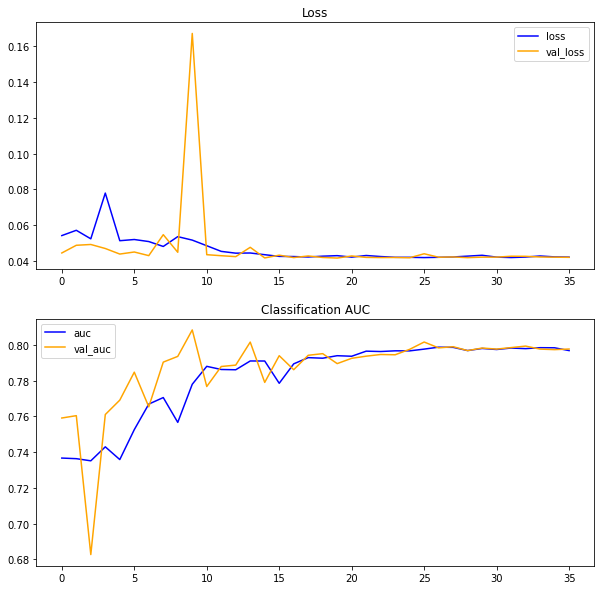

Accuracy: mean=383.519 std=0.000, n=1


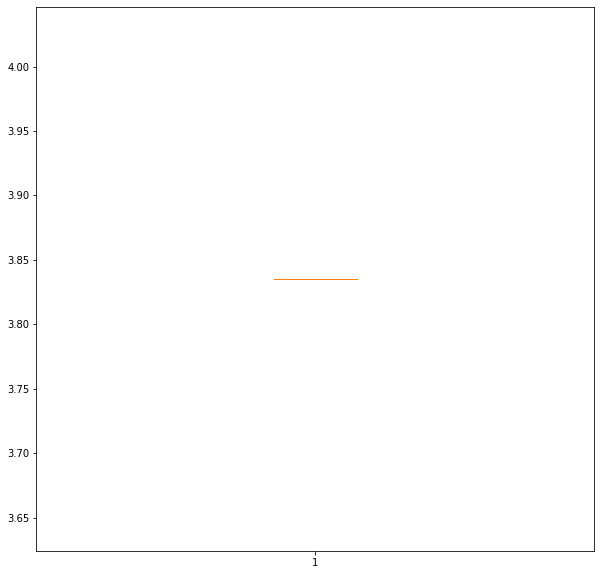

Scores:  [3.8351917266845703]


In [12]:
# learning curves
print(histories[0].history.keys() )
summarize_diagnostics(histories)
# summarize estimated performance
summarize_performance(scores)
 
print("Scores: ",scores)


Build an ensamble of networks trained using k-folding and test it on test data

---



In [13]:
#ensamble of networks
def test_ensamble(x_test_all, y_test_all, sw_test_all):
  
  #Limit the number of events
  n_events = 100000
  x_test_all, y_test_all, sw_test_all = x_test_all[0:n_events], y_test_all[0:n_events], sw_test_all[0:n_events]


  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  np_y_test_all = y_test_all.to_numpy()
  np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()



  # normalize test data
  np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  # replace negative values by zero
  #summed[summed<0] = 0
  #summed_s[summed_s<0] = 0
  #summed_b[summed_b<0] = 0
  
  # func to calculate auc

  fpr, tpr, tresholds = roc_curve(np_y_test_all, summed, sample_weight=np_sw_test_all)

  m = tf.keras.metrics.AUC(num_thresholds=1000)
  m.update_state(np_y_test_all, summed, sample_weight=np_sw_test_all)
  r_auc = m.result().numpy()
  print("r_auc (ensamble) == ",r_auc)

  aucs = []
  for i in range(len(models)):
    yyhats = models[i].predict(np_x_test_all)[:,0]
    m.update_state(np_y_test_all, yyhats, sample_weight=np_sw_test_all)
    aucs.append(m.result().numpy())

  av_auc = np.mean(aucs)

  

  #plot roc
  plt.figure(figsize=(6,4))
  plt.plot(1-fpr,tpr)
  plt.xlabel("Efficiency")
  plt.ylabel("Rejection")
  plt.title("ROC curve")
  plt.show()

  summed = summed.reshape((len(summed),1))
  summed_s = summed_s.reshape((len(summed_s),1))
  summed_b = summed_b.reshape((len(summed_b),1))

  
  plt.figure(figsize=(6,4))
  plt.hist(summed_s, weights=np_sw_test_all_s, bins=200, label="Signal",log=False, alpha=0.5, histtype='stepfilled')  
  plt.hist(summed_b, weights=np_sw_test_all_b, bins=200, label="Bckg.",log=False, alpha=0.5, histtype='stepfilled')
  plt.ylim(bottom=0)
  plt.xlabel("probability")
  plt.legend()
  plt.show()

  return r_auc, av_auc, aucs

Test accuracy

In [14]:
def accuracy_ensamble(x_test_all, y_test_all, sw_test_all):

  mask_s = np.in1d(y_test_all.vClass, 1.)
  mask_b = np.in1d(y_test_all.vClass, 0.)

  #test data
  #np_x_test_all = x_test_all.to_numpy()
  np_x_test_all_s = x_test_all[mask_s].to_numpy()
  np_x_test_all_b = x_test_all[mask_b].to_numpy()
  #np_y_test_all = y_test_all.to_numpy()
  #np_sw_test_all = sw_test_all.to_numpy()
  np_sw_test_all_s = sw_test_all[mask_s].to_numpy()
  np_sw_test_all_b = sw_test_all[mask_b].to_numpy()

  np_sw_test_all_s = np_sw_test_all_s.reshape((len(np_sw_test_all_s)))
  np_sw_test_all_b = np_sw_test_all_b.reshape((len(np_sw_test_all_b)))

  # normalize test data
  #np_x_test_all = np.array(layer(np_x_test_all))
  np_x_test_all_s = np.array(layer(np_x_test_all_s))
  np_x_test_all_b = np.array(layer(np_x_test_all_b))


  # make predictions
  #yhats = [model.predict(np_x_test_all)[:,0] for model in models]
  yhats_s = [model.predict(np_x_test_all_s)[:,0] for model in models]
  yhats_b = [model.predict(np_x_test_all_b)[:,0] for model in models]

  # sum across ensambles
  #summed = np.sum(yhats, axis=0)/len(models)
  summed_s = np.sum(yhats_s, axis=0)/len(models)
  summed_b = np.sum(yhats_b, axis=0)/len(models)

  cut=0.5
  summed_s[summed_s>cut] = 1
  summed_s[summed_s<cut] = 0
  summed_b[summed_b>cut] = 1
  summed_b[summed_b<cut] = 0

  isummed_s = summed_s.astype(np.int32)
  isummed_b = summed_b.astype(np.int32)


  false_neg, true_pos = np.bincount(isummed_s, weights=np_sw_test_all_s)
  #false_neg=np.bincount((1-isummed_s), weights=np_sw_test_all_s)
  true_neg, false_pos = np.bincount(isummed_b, weights=np_sw_test_all_b)
  #false_pos=np.bincount((1-isummed_b), weights=np_sw_test_all_b)

  #print("true_pos = ",true_pos)
  #print("false_neg = ",false_neg)
  #print("true_neg = ",true_neg)
  print("false_pos = ",false_pos)

  sensitivity = true_pos / (true_pos+false_neg)
  specificity = true_neg / (true_neg+false_pos)
  accuracy    = (true_pos + true_neg)/(true_pos + true_neg + false_neg + false_pos)

  print("accuracy = ",accuracy,", specificity = ", specificity,", sensitivity = ", sensitivity)

  return accuracy, specificity, sensitivity

Split test data according to signal_mass and test the classifier performance separately on each subsample

signal_mass =  200
r_auc (ensamble) ==  0.95935893


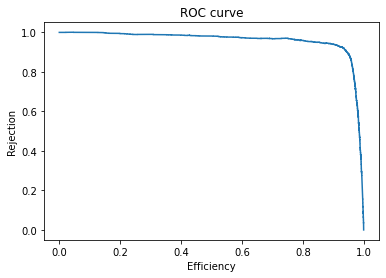

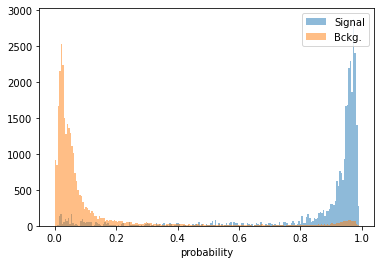

false_pos =  26203.883583546158
accuracy =  0.929288745499562 , specificity =  0.9348418242634398 , sensitivity =  0.9237406890106711
-------------------------------------------
signal_mass =  250
r_auc (ensamble) ==  0.97886586


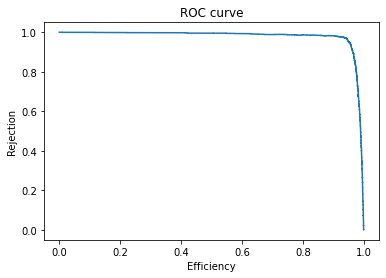

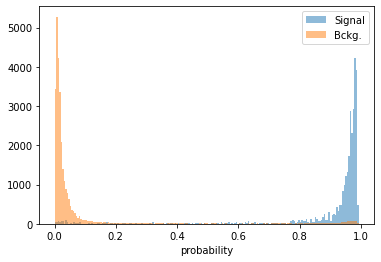

false_pos =  22416.33622936274
accuracy =  0.9522260295449215 , specificity =  0.944266971489123 , sensitivity =  0.9601892790982982
-------------------------------------------
signal_mass =  300
r_auc (ensamble) ==  0.98801434


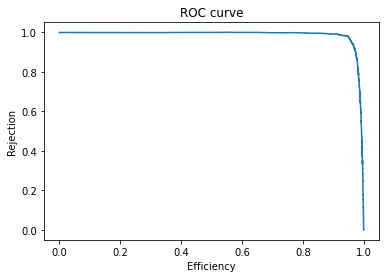

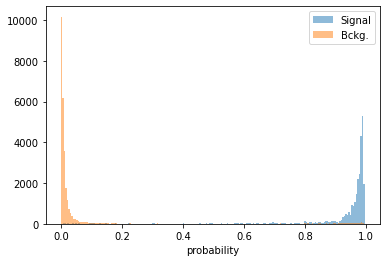

false_pos =  20179.040627454804
accuracy =  0.9628831834881167 , specificity =  0.9498299435141371 , sensitivity =  0.9759551113940117
-------------------------------------------
signal_mass =  350
r_auc (ensamble) ==  0.9897392


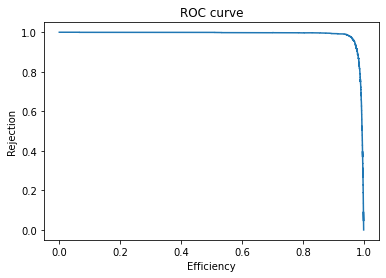

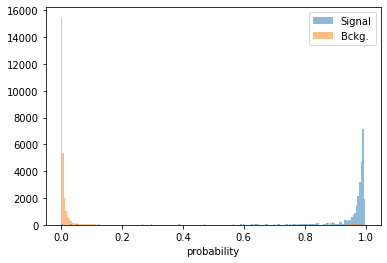

false_pos =  17720.82067270122
accuracy =  0.9688112083595332 , specificity =  0.9559232915876636 , sensitivity =  0.9817023033798918
-------------------------------------------
signal_mass =  400
r_auc (ensamble) ==  0.99345523


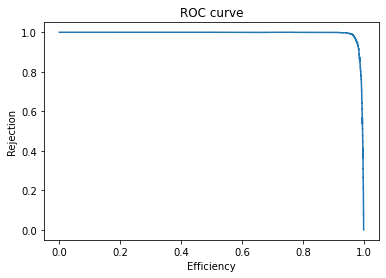

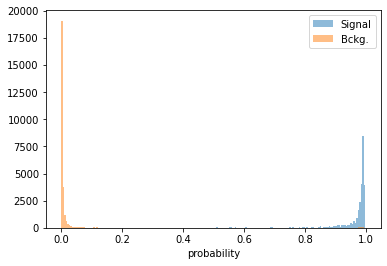

false_pos =  15473.35783350925
accuracy =  0.9730970420665975 , specificity =  0.9615335285728335 , sensitivity =  0.9846541034628843
-------------------------------------------
signal_mass =  500
r_auc (ensamble) ==  0.9958281


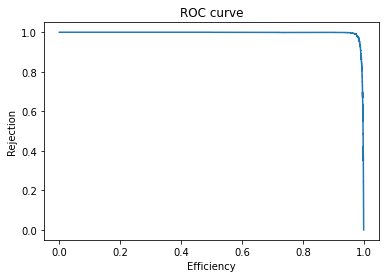

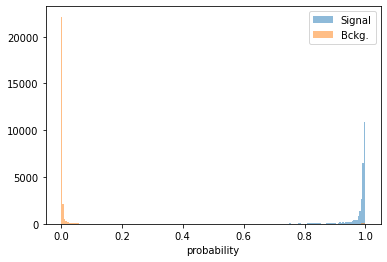

false_pos =  11523.878945446873
accuracy =  0.9797525166677438 , specificity =  0.9713409938225047 , sensitivity =  0.9881674217784914
-------------------------------------------
signal_mass =  600
r_auc (ensamble) ==  0.9967754


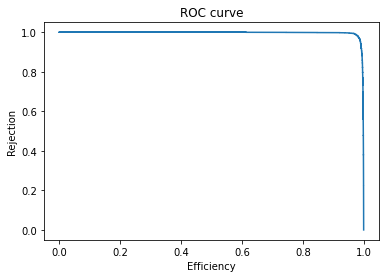

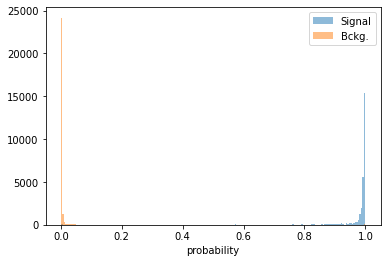

false_pos =  8965.23490965308
accuracy =  0.9836376655878717 , specificity =  0.9776961638882162 , sensitivity =  0.9895804968087701
-------------------------------------------
signal_mass =  700
r_auc (ensamble) ==  0.9979834


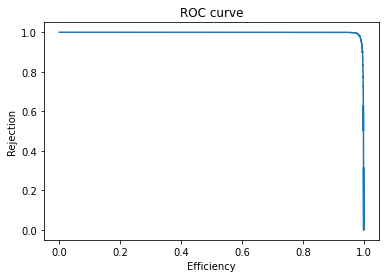

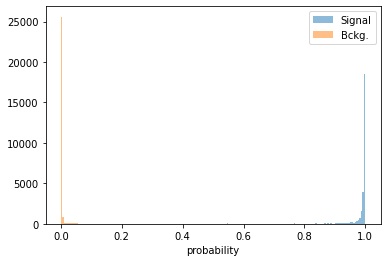

false_pos =  7666.747686367047
accuracy =  0.9863253414998956 , specificity =  0.9809345014977104 , sensitivity =  0.9917191083388703
-------------------------------------------
signal_mass =  800
r_auc (ensamble) ==  0.9983508


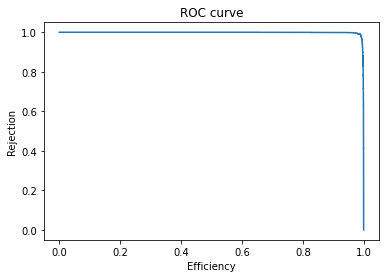

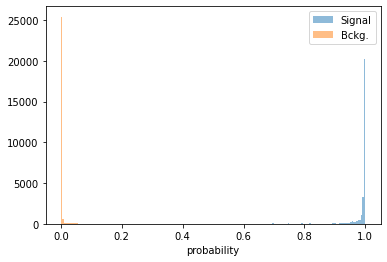

false_pos =  6443.201957735074
accuracy =  0.987569246952234 , specificity =  0.9839759538209802 , sensitivity =  0.9911640962978793
-------------------------------------------
signal_mass =  1200
r_auc (ensamble) ==  0.9991498


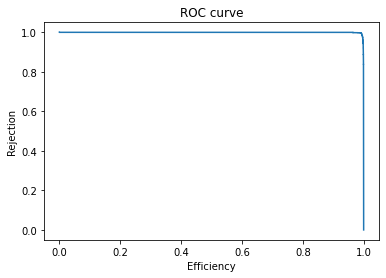

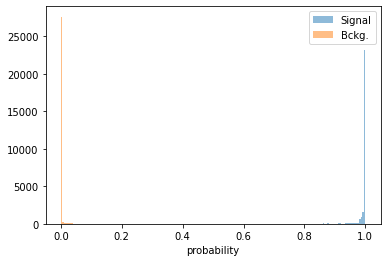

false_pos =  3466.2460537767142
accuracy =  0.991944191554446 , specificity =  0.991378375293887 , sensitivity =  0.9925099051041799
-------------------------------------------
signal_mass =  1500
r_auc (ensamble) ==  0.99972993


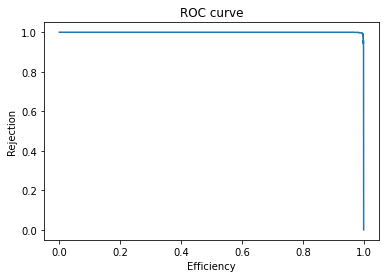

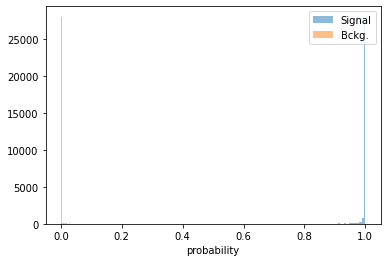

false_pos =  2331.8439530142355
accuracy =  0.9947665677552803 , specificity =  0.9942041356379165 , sensitivity =  0.9953283340888365
-------------------------------------------
signal_mass =  2000
r_auc (ensamble) ==  1.0001045


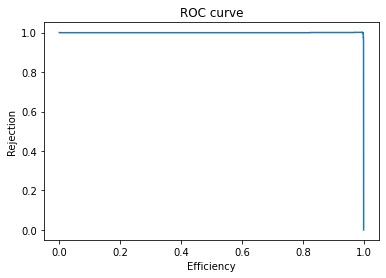

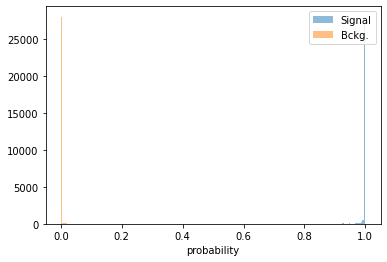

false_pos =  1287.112938269829
accuracy =  0.996915076692604 , specificity =  0.996800041992798 , sensitivity =  0.9970302061169586
-------------------------------------------
signal_mass =  2500
r_auc (ensamble) ==  1.0001547


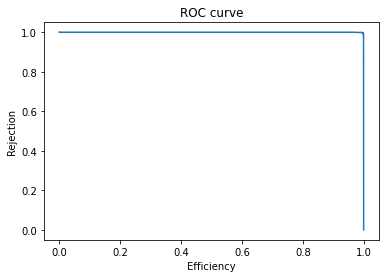

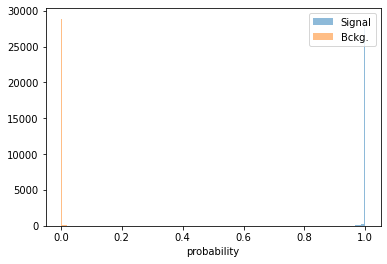

false_pos =  838.3757098419497
accuracy =  0.9978403581897853 , specificity =  0.9979152700417712 , sensitivity =  0.9977653324413222
-------------------------------------------


In [15]:
auc_list = []
av_auc_list = []
aucs_list = []

acc_list = []
spec_list = []
sens_list = []

for m in masses:
  print("signal_mass = ",m)
  #mask = np.in1d(x_test_all.signal_mass, m)
  mask = np.in1d(x_train_all.signal_mass, m)

  #x_test_m = x_test_all[mask]
  #y_test_m = y_test_all[mask]
  #sw_test_m = sw_test_all[mask]

  x_test_m = x_train_all[mask]
  y_test_m = y_train_all[mask]
  sw_test_m = sw_train_all[mask]

  auc, av_auc, aucs = test_ensamble(x_test_m, y_test_m, sw_test_m)
  auc_list.append(auc)
  av_auc_list.append(av_auc)
  aucs_list.append(aucs)

  accuracy, specificity, sensitivity = accuracy_ensamble(x_test_m, y_test_m, sw_test_m)
  acc_list.append(accuracy)
  spec_list.append(specificity)
  sens_list.append(sensitivity)
  
  print("-------------------------------------------")


Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

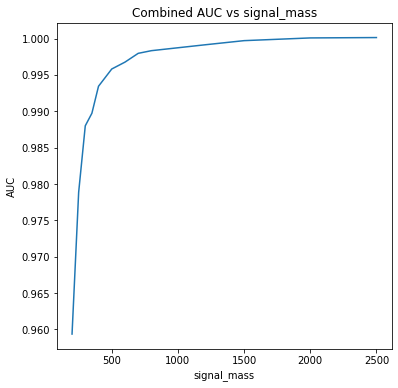

[0.95935893]


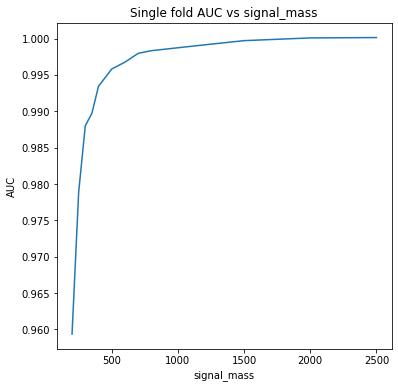

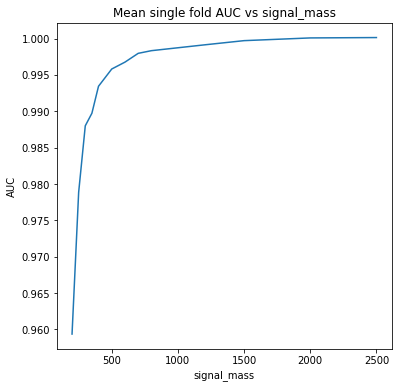

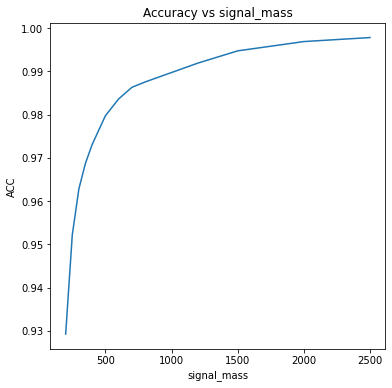

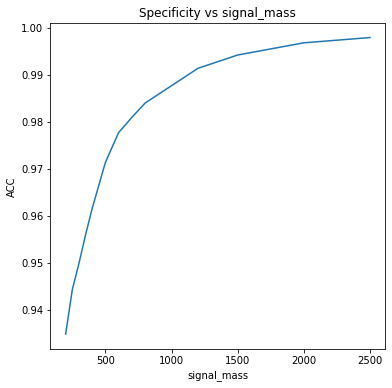

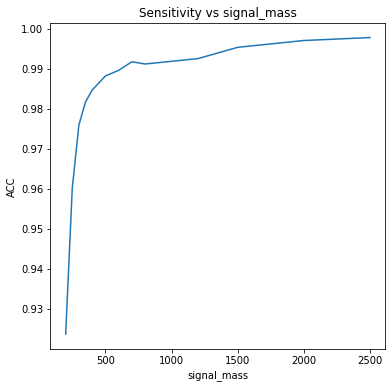

,signal_mass,comb. auc,mean auc,acc,specificity,sensitivity
0,200,0.959359,0.959359,0.929289,0.934842,0.923741
1,250,0.978866,0.978866,0.952226,0.944267,0.960189
2,300,0.988014,0.988014,0.962883,0.949830,0.975955
3,350,0.989739,0.989739,0.968811,0.955923,0.981702
4,400,0.993455,0.993455,0.973097,0.961534,0.984654
5,500,0.995828,0.995828,0.979753,0.971341,0.988167
6,600,0.996775,0.996775,0.983638,0.977696,0.989580
7,700,0.997983,0.997983,0.986325,0.980935,0.991719
8,800,0.998351,0.998351,0.987569,0.983976,0.991164
9,1200,0.999150,0.999150,0.991944,0.991378,0.992510


In [16]:

plt.figure(figsize=(6,6))
plt.plot(masses, np.array(auc_list))
plt.title('Combined AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()

print(aucs_list[0])

plt.figure(figsize=(6,6))
for i in range(len(aucs_list[0])):
  aux=[]
  for k in range(len(aucs_list)):
    aux.append(aucs_list[k][i])
  plt.plot(masses, np.array(aux))
plt.title('Single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(av_auc_list))
plt.title('Mean single fold AUC vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(acc_list))
plt.title('Accuracy vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(spec_list))
plt.title('Specificity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


plt.figure(figsize=(6,6))
plt.plot(masses, np.array(sens_list))
plt.title('Sensitivity vs signal_mass')
plt.xlabel("signal_mass")
plt.ylabel("ACC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list, av_auc_list, acc_list, spec_list, sens_list)), 
               columns =['signal_mass', 'comb. auc', 'mean auc', 'acc', 'specificity', 'sensitivity']) 
aucf

Stop program execution

In [17]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Split test data according to signal_mass, than train and test a network separately for each subsample. 

In [ ]:
auc_list_sep = []

for m in masses:
  print("signal_mass = ",m)

  #select events with a given signal_mass from the training dataset...
  mask = np.in1d(x_train_all.signal_mass, m)

  x_train_m = x_train_all[mask]
  y_train_m = y_train_all[mask]
  sw_train_m = sw_train_all[mask]

  # ...and from the test dataset
  mask = np.in1d(x_test_all.signal_mass, m)

  x_test_m = x_test_all[mask]
  y_test_m = y_test_all[mask]
  sw_test_m = sw_test_all[mask]

  # train the network
  scores, histories, models = network_fit(x_train_m, y_train_m, sw_train_m)

  # learning curves
  print(histories[1].history.keys() )
  summarize_diagnostics(histories)
  # summarize estimated performance
  summarize_performance(scores)
  
  print("Scores: ",scores)

  # and now test the model
  auc_list_sep.append(test_ensamble(x_test_m, y_test_m, sw_test_m))

Plot the dependence of AUC (Area Under Curve of ROC) on signal_mass 

In [ ]:

plt.figure(figsize=(6,6))
plt.plot(masses,auc_list_sep)
plt.title('AUC vs signal_mass (separate nets)')
plt.xlabel("signal_mass")
plt.ylabel("AUC")
plt.show()


# Calling DataFrame constructor after zipping 
# both lists, with columns specified 
aucf = pd.DataFrame(list(zip(masses, auc_list_sep)), 
               columns =['signal_mass', 'auc']) 
aucf